In [2]:
import  cv2
import  glob
import  numpy  as np
from  itertools  import  permutations
from  matplotlib  import  pyplot  as plt
from torchvision import models, transforms
import torch.nn.functional as F
from torch import nn,flatten
import torch
from  sklearn.model_selection  import   train_test_split
from  sklearn  import  metrics
import random
train_images_address = "dataset/trainingSet/trainingSet/"
# Normalizer used for pretrained models
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

code to read in the dataset
--

In [3]:
class Dataset():
    def  __init__(self):
        self.train_digits_add_dic = {}
        self.data = np.zeros ((30000 ,4),dtype=int)
        self.data_label = np.zeros ((30000 ,1),dtype=int)

        self.exercise_data = np.zeros ((5050 ,4),dtype=int)
        self.exercise_data_label = np.zeros ((5050 ,1),dtype=int)

        self.class_metadata = {0:{'sequences':[],'class_name':'C','info':'The sequences  of this  class follow a constant trend'},
                               1:{'sequences':[],'class_name':'I','info':'The sequences  of this  class follow an incremental trend'},
                               2:{'sequences':[],'class_name':'D','info':'The sequences  of this  class follow a decremental trend'},
                               3:{'sequences':[],'class_name':'I_D','info':'The sequences  of this  class follow an incremental trend, followed by a decremental trend'},
                               4:{'sequences':[],'class_name':'D_I','info':'The sequences  of this  class follow a decremental trend, followed by an incremental trend'},
                               5:{'sequences':[],'class_name':'I_D_I','info':'The sequences  of this  class follow n incremental trend, followed by a decremental trend, followed by an incremental trend'},
                               6:{'sequences':[],'class_name':'D_I_D','info':'The sequences  of this  class follow a decremental trend, followed by an incremental trend, followed by a decremental trend'},
                               }

    def  reading_imgs_address(self):
        for i in  range (10):
            imgs_add = []
            for  img_add  in glob.glob(train_images_address+str(i)+'/*.jpg'):
                imgs_add.append(img_add)
            self.train_digits_add_dic[i] = imgs_add

    def  generate_class_sequences(self):
        perm = permutations ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 4)
        counter = 0
        for j,sequence  in  enumerate(list(perm)):
            if (sequence [3] > sequence [2])  and (sequence [2] > sequence [1])  and (sequence [1] > sequence [0]):
                self.class_metadata [1]['sequences']. append(sequence)
                self.exercise_data[j,:]= sequence
                self.exercise_data_label[j,0] = 1
            if (sequence [3] < sequence [2])  and (sequence [2] < sequence [1])  and (sequence [1] < sequence [0]):
                self.class_metadata [2]['sequences']. append(sequence)
                self.exercise_data[j, :] = sequence
                self.exercise_data_label[j, 0] = 2
            if (sequence [3] < sequence [2])  and (sequence [2] > sequence [1])  and (sequence [1] > sequence [0]):
                self.class_metadata [3]['sequences']. append(sequence)
                self.exercise_data[j, :] = sequence
                self.exercise_data_label[j, 0] = 3
            if (sequence [3] < sequence [2])  and (sequence [2] < sequence [1])  and (sequence [1] > sequence [0]):
                self.class_metadata [3]['sequences']. append(sequence)
                self.exercise_data[j, :] = sequence
                self.exercise_data_label[j, 0] = 3
            if (sequence [3] > sequence [2])  and (sequence [2] < sequence [1])  and (sequence [1] < sequence [0]):
                self.class_metadata [4]['sequences']. append(sequence)
                self.exercise_data[j, :] = sequence
                self.exercise_data_label[j, 0] = 4
            if (sequence [3] > sequence [2])  and (sequence [2] > sequence [1])  and (sequence [1] < sequence [0]):
                self.class_metadata [4]['sequences']. append(sequence)
                self.exercise_data[j, :] = sequence
                self.exercise_data_label[j, 0] = 4
            if (sequence [3] > sequence [2])  and (sequence [2] < sequence [1])  and (sequence [1] > sequence [0]):
                self.class_metadata [5]['sequences']. append(sequence)
                self.exercise_data[j, :] = sequence
                self.exercise_data_label[j, 0] = 5
            if (sequence [3] < sequence [2])  and (sequence [2] > sequence [1])  and (sequence [1] < sequence [0]):
                self.class_metadata [6]['sequences']. append(sequence)
                self.exercise_data[j, :] = sequence
                self.exercise_data_label[j, 0] = 6
            counter = j
        for i in  range (10):
            counter  +=1
            self.class_metadata [0]['sequences'].append((i,i,i,i))
            self.exercise_data[counter , :] = (i,i,i,i)
            self.exercise_data_label[counter , 0] = 0
        for i in range(30000):
            label=random.randint(0,6)
            seq=random.choice(self.class_metadata[label]['sequences'])
            self.data[i,:]=seq
            self.data_label[i,0]=label

    def load_images(self , sequences):
        images = np.zeros((sequences.shape[0], sequences.shape[1],28 ,28))
        for i in range(sequences.shape[0]):
            for j in range(sequences[i].shape[0]):
                imgs_add = self.train_digits_add_dic[sequences[i][j]]
                random_image_add = imgs_add[random.randint(0, len(imgs_add)-1)]
                img = cv2.imread(random_image_add)
                # img=np.swapaxes(img,1,2)
                # img=np.swapaxes(img,0,1)
                images[i,j,:] = img[:,:,0]
        return images
    def load_images_modified(self, sequences):
        images = np.zeros((sequences.shape[0], 3 ,224 ,224))
        for i in range(sequences.shape[0]):
            sub_image=None
            started=False
            for j in range(sequences[i].shape[0]):
                imgs_add = self.train_digits_add_dic[sequences[i][j]]
                random_image_add = imgs_add[random.randint(0, len(imgs_add)-1)]
                img = cv2.imread(random_image_add)
                img=cv2.resize(img,(56,224), interpolation = cv2.INTER_AREA)
                if(not started):
                    sub_image=img
                    started=True
                else:
                    sub_image=np.append(sub_image,img,axis=1)
            sub_image=np.swapaxes(sub_image,1,2)
            sub_image=np.swapaxes(sub_image,0,1)
            for j in range(2):
                images[i,j,:] = sub_image[j,:,:]
        return images

    def  plot(self ,class_indx):
        sequences = self.class_metadata[class_indx ]['sequences']
        random_sequence = sequences[random.randint(0,len(sequences))]
        seq_imgs_add = []
        for i in  range(len(random_sequence)):
            img_label = random_sequence[i]
            images_add = self.train_digits_add_dic[img_label]
            random_image_add = images_add[random.randint(0,len(images_add))]
            seq_imgs_add.append(random_image_add)
        fig = plt.figure(figsize =(20 ,20), dpi =40)
        fig.set_size_inches (35, 10)
        columns = len(seq_imgs_add)
        rows = 1
        for i in  range(columns):
            img = cv2.imread(seq_imgs_add[i])
            fig.add_subplot(rows , columns , i+1)
            plt.imshow(img)
        fig.suptitle('class  name : {}\n info: {}'.format(self.class_metadata[class_indx ]['class_name'],self.class_metadata[class_indx ]['info']),fontsize =50)
        plt.show()

In [4]:
device = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')
batch_size = 10
iter=0
dataset = Dataset()
dataset.reading_imgs_address()
dataset.generate_class_sequences()
x_train , x_test , y_train , y_test = train_test_split(dataset.data , dataset.data_label, test_size =0.15,  random_state =42)
if np.mod(x_train.shape[0], batch_size) == 0.0:
    iter =   int(x_train.shape [0]/ batch_size)
else:
    iter = int(x_train.shape [0] / batch_size) + 1
test=dataset.load_images(x_train[0:batch_size])
bs = 0
iter_list_train=list()
train_images=list()
for i in  range(iter):
    sequences = x_train[bs:bs+batch_size ,:]
    labels = y_train[bs:bs+batch_size]
    input_images = dataset.load_images(sequences)
    for j in input_images:
        train_images.append(j)
    input_images=torch.from_numpy(input_images.astype("float32"))
    iter_list_train.append([sequences,labels,input_images])
    bs+=batch_size
iter_list_test=list()
test_images=list()
bs = 0
for i in range(int(x_test.shape[0]/batch_size)+1):
    sequences = x_test[bs:bs+batch_size ,:]
    labels = y_test[bs:bs+batch_size]
    input_images = dataset.load_images(sequences)
    for j in input_images:
        test_images.append(j)
    input_images=torch.from_numpy(input_images.astype("float32"))
    iter_list_test.append([sequences,labels,input_images])
    bs+=batch_size

Start creation neural networks
--

LSTM based
--

In [4]:
class lstm(nn.Module):
    def __init__(self,dropout=0.25):
        super().__init__ ()
        self.lstm = nn.LSTM(784 , #create  LSTM\
                            500 ,
                            num_layers=3,
                            bidirectional=True ,
                            dropout=dropout ,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.relu=nn.LeakyReLU(0.1)
        self.fc1 = nn.Linear(4000, 500)
        self.fc2 = nn.Linear(500 , 7)

    def forward(self,x):
        h0 = torch.zeros(6, x.size(0), 500).requires_grad_()
        h0=h0.to(device)
        c0 = torch.zeros(6, x.size(0), 500).requires_grad_()
        c0=c0.to(device)
        x=x.view(batch_size,    +4, -1)

        packed_output , (hidden , cell) = self.lstm(x,(h0, c0))
        # x=torch.cat(( hidden[-2,:,:], hidden [-1,:,:]), dim = 1)
        x=flatten(packed_output,1)
        x = self.fc1(x)
        x=self.relu(x)

        x = self.dropout(self.fc2(x))
        output=F.softmax(x,dim=1)
        return output

CNN based
--

In [5]:
class cnn(nn.Module):
    def __init__(self,dropout=0.25):
        super(cnn, self).__init__()

        self.conv1=nn.Conv2d(4,16,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0)
        # self.conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0)
        self.fc1=nn.Linear(400,100)
        self.fc2=nn.Linear(100,100)
        self.fc3=nn.Linear(100,100)
        self.fc4=nn.Linear(100,7)
        # self.fc = nn.Linear(46656, 15)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv2(x))
        x=F.max_pool2d(x,2)
        x=flatten(x,1)
        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc2(x)
        x=F.relu(x)
        x=self.fc3(x)
        x=F.relu(x)
        x=self.dropout(self.fc4(x))
        output=F.softmax(x,dim=1)
        return output

CNN vgg19 based
--
This one eas eventually not used because the 3*224*224 images would end up taking up too much vram, slowing down the training process too much to bee usefull

In [ ]:
class cnn_vgg19(nn.Module):
    def __init__(self,dropout=0.25):
        super(cnn_vgg19, self).__init__()

        self.feature_extraction=models.vgg19(pretrained=True)
        num_ftrs=self.feature_extraction.classifier[6].in_features
        self.feature_extraction.classifier[6]=nn.Linear(num_ftrs,7)
        # self.fc1=nn.Linear(700,350)
        # self.fc2=nn.Linear(350,350)
        # self.fc3=nn.Linear(350,7)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        x=normalize.forward(x)
        x=self.feature_extraction.forward(x)
        # x=self.fc1.forward(x)
        # x=self.fc2.forward(x)
        # x=self.fc3.forward(x)
        return x

CNN and lstm based
--

In [5]:
class cnn_lstm(nn.Module):
    def __init__(self,dropout=0.25):
        super(cnn_lstm, self).__init__()

        self.conv1=nn.Conv2d(1,50,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(50, 50, kernel_size=3, stride=1, padding=0)
        self.lstm = nn.LSTM(1250 , #create  LSTM\
                            500,
                            num_layers=4,
                            bidirectional=True ,
                            dropout=dropout ,
                            batch_first=True)
        self.fc1=nn.Linear(4000,1000)
        self.fc2=nn.Linear(1000,250)
        self.fc3=nn.Linear(250,7)
        self.dropout = nn.Dropout(dropout)


    def forward(self,x):
        h0 = torch.zeros(8, x.size(0), 500).requires_grad_()
        h0=h0.to(device)
        c0 = torch.zeros(8, x.size(0), 500).requires_grad_()
        c0=c0.to(device)
        x=x.view(batch_size*4,1,28,28)
        x=F.relu(self.conv1(x))
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv2(x))
        x=F.max_pool2d(x,2)
        x = self.dropout(x)
        x=x.view(batch_size, 4, -1)
        packed_output , (hidden , cell) = self.lstm(x,(h0, c0))
        x=flatten(packed_output,1)
        x=self.fc1.forward(x)
        x=F.relu(x)
        x=self.fc2.forward(x)
        x=F.relu(x)
        x=self.fc3.forward(x)
        x=F.softmax(x,dim=1)
        return x


Training and evaluating of the networks
----

Note that these results might be slightly different than those in the report. when making this notebook ready for sending the assignment all results got deleted so I had to retrain the networks.

In [10]:
class train_network_new_images():
    def __init__(self,model,x_train,y_train,x_test,y_test,epochs,modified=False):
        self.model=model
        self.loss = self.loss_function()
        self.optim=self.optim_function()
        self.epochs=epochs

        self.x_train=x_train
        self.y_train=y_train
        self.x_test=x_test
        self.y_test=y_test
        self.train_loss_history=[]
        self.val_loss_history=[]
        self.modified=modified
        self.fit()

    def loss_function(self):
        return  nn.BCEWithLogitsLoss()

    def optim_function(self):
        return torch.optim.Adam(self.model.parameters (), lr=0.00005)
        # return optim.SGD(filter(lambda p: p.requires_grad, self.model.parameters()),lr=0.0005,momentum=0.9)

    def fit(self):

        for epoch in range(self.epochs):
            print("starting epoch:"+str(epoch))
            temp_loss=0
            itr=0
            bs=0
            while bs<len(self.x_train):
                if(bs+batch_size>len(self.x_train)):
                    bs+=batch_size
                    continue
                #read in the training data, the modified path is for reading in the images with vgg dimensions
                if not self.modified:
                    xb=dataset.load_images(x_train[bs:bs+batch_size,:]).astype("float32")
                else:
                    xb=dataset.load_images_modified(x_train[bs:bs+batch_size,:]).astype("float32")
                #Read in labels and place them in one hot encoded array
                ybData=self.y_train[bs:bs+batch_size]
                yb=np.zeros((len(ybData),7))
                for idx,i in enumerate(ybData):
                    yb[idx,i]=1
                yb=torch.tensor(yb,dtype=torch.float)
                xb=torch.from_numpy(xb).to(device)
                yb=yb.to(device)
                #training
                temp_loss += self.loss_batch(xb,yb)
                bs+=batch_size
                itr+=1
                xb.to('cpu')
                if(bs%500==499):
                    print("trained on 500 images")
            self.train_loss_history.append(temp_loss.item()/itr)
            self.model.eval()
            with torch.no_grad():
                valid_loss=0
                itr=0
                bs=0
                while bs<len(self.x_test):
                    if(bs+batch_size>len(self.x_test)):
                        bs+=batch_size
                        continue
                    if not self.modified:
                        xb=dataset.load_images(x_test[bs:bs+batch_size,:]).astype("float32")
                    else:
                        xb=dataset.load_images_modified(x_test[bs:bs+batch_size,:]).astype("float32")
                    ybData=self.y_test[bs:bs+batch_size]
                    yb=np.zeros((len(ybData),7))
                    for idx,i in enumerate(ybData):
                        yb[idx,i]=1
                    yb=torch.tensor(yb,dtype=torch.float)
                    xb=torch.from_numpy(xb).to(device)
                    yb=yb.to(device)
                    #validtion
                    valid_loss+=self.loss(self.model(xb),yb)
                    bs+=batch_size
                    itr+=1
                    xb.to('cpu')
                self.val_loss_history.append(valid_loss.item()/itr)
            self.model.train()
    def loss_batch(self,xb,yb):
        # print("1")
        loss=self.loss(self.model(xb),yb)
        if self.optim is not None:
            loss.backward()
            self.optim.step()
            self.optim.zero_grad()
        return loss

In [7]:
def plot_trianval_loss(train,val):
    plt.plot(train,color="red",marker=",",linestyle="solid",linewidth=2,markersize=12,label="Train Loss")
    plt.plot(val,color="green",marker=",",linestyle="solid",linewidth=2,markersize=12,label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss")
    plt.legend()
    plt.show()
def print_metrics(network):
    predicts = []
    labels=[]
    #enable to also include trainign data in metrics
    # bs=0
    # while bs<len(x_train):
    #     xb=dataset.load_images(x_train[bs:bs+batch_size,:]).astype("float32")
    #     xb=torch.from_numpy(xb).to(device)
    #     yb=y_train[bs:bs+batch_size]
    #     bs+=batch_size
    #     if(len(yb) is not batch_size):
    #         continue
    #     test=network.forward(xb).cpu().detach().numpy()
    #     # predicts.append(np.where(test==np.amax(test))[1][0])
    #     for i in test:
    #         predicts.append(np.where(i==np.amax(i))[0][0])
    #     for i in yb:
    #         labels.append(i)
    #     xb.to('cpu')
    bs=0
    while bs<len(x_test):
        xb=dataset.load_images(x_test[bs:bs+batch_size,:]).astype("float32")
        xb=torch.from_numpy(xb).to(device)
        yb=y_test[bs:bs+batch_size]
        bs+=batch_size
        if(len(yb) is not batch_size):
            continue
        test=network.forward(xb).cpu().detach().numpy()
        # predicts.append(np.where(test==np.amax(test))[1][0])
        for i in test:
            predicts.append(np.where(i==np.amax(i))[0][0])
        for i in yb:
            labels.append(i)
        xb.to('cpu')
    print(metrics.classification_report(labels, predicts))
    cm=metrics.confusion_matrix(labels, predicts)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['C','I','D','ID','DI','IDI','DID'])
    disp.plot()

train and evaluate cnn network

creating network
training network
starting epoch:0
starting epoch:1
starting epoch:2
starting epoch:3
starting epoch:4
starting epoch:5
starting epoch:6
starting epoch:7
starting epoch:8
starting epoch:9
starting epoch:10
starting epoch:11
starting epoch:12
starting epoch:13
starting epoch:14
starting epoch:15
starting epoch:16
starting epoch:17
starting epoch:18
starting epoch:19
starting epoch:20
starting epoch:21
starting epoch:22
starting epoch:23
starting epoch:24
starting epoch:25
starting epoch:26
starting epoch:27
starting epoch:28
starting epoch:29
starting epoch:30
starting epoch:31
starting epoch:32
starting epoch:33
starting epoch:34
starting epoch:35
starting epoch:36
starting epoch:37
starting epoch:38
starting epoch:39
starting epoch:40
starting epoch:41
starting epoch:42
starting epoch:43
starting epoch:44
starting epoch:45
starting epoch:46
starting epoch:47
starting epoch:48
starting epoch:49
starting epoch:50
starting epoch:51
starting epoch:52
starting epoch:53
star

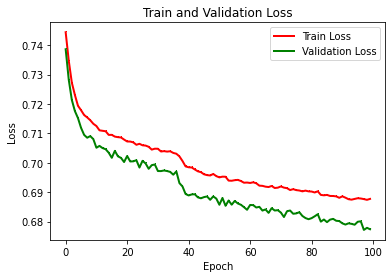

In [10]:
batch_size=200
print("creating network")
# Toggle to switch between own network and vgg16
cnn_network=cnn(dropout=0.2)
cnn_network.to(device)
print("training network")
train =train_network_new_images(cnn_network,x_train,y_train,x_test,y_test,100)

print(train.train_loss_history)
print(train.val_loss_history)
print("finished training")
print("creating plots")
plot_trianval_loss(train.train_loss_history,train.val_loss_history)

              precision    recall  f1-score   support

           0       0.77      0.89      0.82       659
           1       0.62      0.80      0.70       594
           2       0.67      0.70      0.68       631
           3       0.53      0.54      0.53       632
           4       0.71      0.48      0.57       606
           5       0.66      0.61      0.64       648
           6       0.67      0.58      0.62       630

    accuracy                           0.66      4400
   macro avg       0.66      0.66      0.65      4400
weighted avg       0.66      0.66      0.65      4400



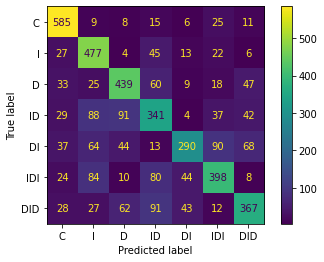

In [11]:
print_metrics(cnn_network)

train and evaluate lstm network

creating network
training network
starting epoch:0
starting epoch:1
starting epoch:2
starting epoch:3
starting epoch:4
starting epoch:5
starting epoch:6
starting epoch:7
starting epoch:8
starting epoch:9
starting epoch:10
starting epoch:11
starting epoch:12
starting epoch:13
starting epoch:14
starting epoch:15
starting epoch:16
starting epoch:17
starting epoch:18
starting epoch:19
starting epoch:20
starting epoch:21
starting epoch:22
starting epoch:23
starting epoch:24
starting epoch:25
starting epoch:26
starting epoch:27
starting epoch:28
starting epoch:29
starting epoch:30
starting epoch:31
starting epoch:32
starting epoch:33
starting epoch:34
starting epoch:35
starting epoch:36
starting epoch:37
starting epoch:38
starting epoch:39
starting epoch:40
starting epoch:41
starting epoch:42
starting epoch:43
starting epoch:44
starting epoch:45
starting epoch:46
starting epoch:47
starting epoch:48
starting epoch:49
starting epoch:50
starting epoch:51
starting epoch:52
starting epoch:53
star

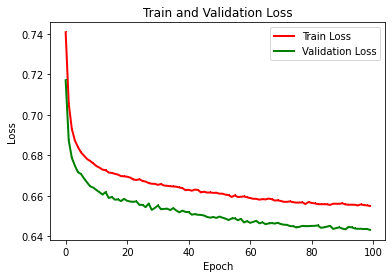

In [12]:
batch_size=200
print("creating network")
# Toggle to switch between own network and vgg16
lstm_network=lstm(dropout=0.2)
lstm_network.to(device)
print("training network")
train =train_network_new_images(lstm_network,x_train,y_train,x_test,y_test,100)

print(train.train_loss_history)
print(train.val_loss_history)
print("finished training")
print("creating plots")
plot_trianval_loss(train.train_loss_history,train.val_loss_history)

              precision    recall  f1-score   support

           0       0.81      0.98      0.89       659
           1       0.81      0.91      0.86       594
           2       0.85      0.92      0.88       631
           3       0.87      0.84      0.85       632
           4       0.92      0.85      0.88       606
           5       0.93      0.82      0.87       648
           6       0.97      0.77      0.86       630

    accuracy                           0.87      4400
   macro avg       0.88      0.87      0.87      4400
weighted avg       0.88      0.87      0.87      4400



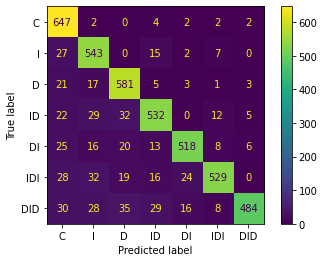

In [13]:
print_metrics(lstm_network)

train and evaluate cnn_lstm network

creating network
training network
starting epoch:0
starting epoch:1
starting epoch:2
starting epoch:3
starting epoch:4
starting epoch:5
starting epoch:6
starting epoch:7
starting epoch:8
starting epoch:9
starting epoch:10
starting epoch:11
starting epoch:12
starting epoch:13
starting epoch:14
starting epoch:15
starting epoch:16
starting epoch:17
starting epoch:18
starting epoch:19
starting epoch:20
starting epoch:21
starting epoch:22
starting epoch:23
starting epoch:24
starting epoch:25
starting epoch:26
starting epoch:27
starting epoch:28
starting epoch:29
starting epoch:30
starting epoch:31
starting epoch:32
starting epoch:33
starting epoch:34
starting epoch:35
starting epoch:36
starting epoch:37
starting epoch:38
starting epoch:39
starting epoch:40
starting epoch:41
starting epoch:42
starting epoch:43
starting epoch:44
starting epoch:45
starting epoch:46
starting epoch:47
starting epoch:48
starting epoch:49
starting epoch:50
starting epoch:51
starting epoch:52
starting epoch:53
star

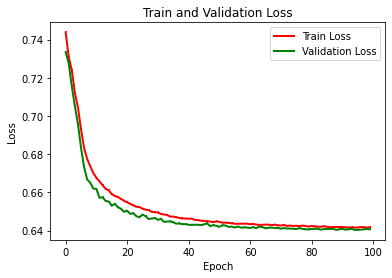

In [11]:
batch_size=200
print("creating network")
# Toggle to switch between own network and vgg16
cnn_lstm_network=cnn_lstm(dropout=0.2)
cnn_lstm_network.to(device)
print("training network")
train =train_network_new_images(cnn_lstm_network,x_train,y_train,x_test,y_test,100)

print(train.train_loss_history)
print(train.val_loss_history)
print("finished 1 training")
print("creating plots")

plot_trianval_loss(train.train_loss_history,train.val_loss_history)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       625
           1       1.00      0.98      0.99       640
           2       0.96      0.99      0.98       614
           3       0.96      0.96      0.96       621
           4       0.97      0.99      0.98       611
           5       0.99      0.98      0.98       650
           6       0.97      0.97      0.97       639

    accuracy                           0.98      4400
   macro avg       0.98      0.98      0.98      4400
weighted avg       0.98      0.98      0.98      4400



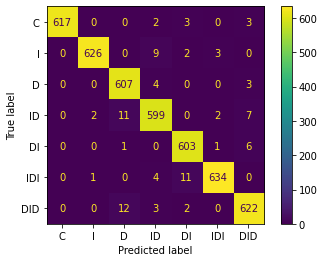

In [12]:
batch_size=200
print_metrics(cnn_lstm_network)
